In [1]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 99999.0, 'width': 3781, 'height': 4451, 'count': 14, 'crs': CRS.from_epsg(32643), 'transform': Affine(50.0, 0.0, 607475.0,
       0.0, -50.0, 1743025.0)}


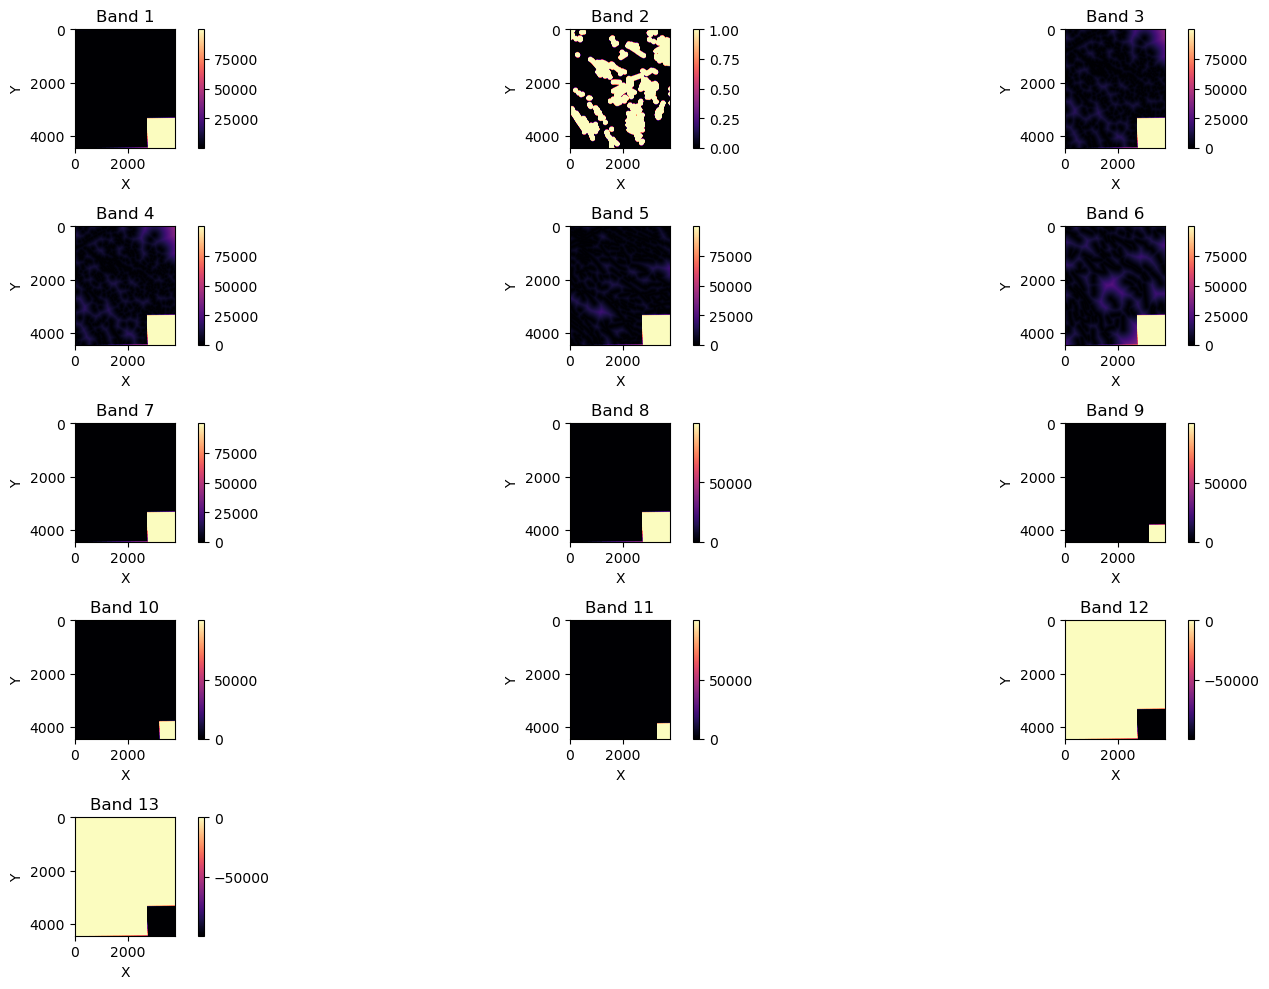

In [2]:
# Path to your TIFF file
tiff_path = r'../RF/cu_input.tiff'

# Open the TIFF file
with rasterio.open(tiff_path) as dataset:
    # Read the first band (assuming single-band grayscale image)
    band1 = dataset.read(1)
    band2 = dataset.read(2)
    band3 = dataset.read(3)
    band4 = dataset.read(4)
    band5 = dataset.read(5)
    band6 = dataset.read(6)
    band7 = dataset.read(7)
    band8 = dataset.read(8)
    band9 = dataset.read(9)
    band10 = dataset.read(10)
    band11 = dataset.read(11)
    band12 = dataset.read(12)
    band13 = dataset.read(13)
    # Get the metadata
    meta = dataset.meta

    # Print metadata
    print(meta)
    
    # List of bands
    bands = [band1, band2, band3, band4, band5, band6, band7, band8, band9, band10, band11, band12, band13]
    
    # Create figure and axes
    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 10))
    
    # Flatten axes array for easy iteration
    axes = axes.flatten()
     
    # Plot each band
    for i, band in enumerate(bands):
        im = axes[i].imshow(band, cmap='magma')
        axes[i].set_title(f'Band {i+1}')
        axes[i].set_xlabel('X')
        axes[i].set_ylabel('Y')
        fig.colorbar(im, ax=axes[i])
    
    # Turn off unused subplots (2 empty ones in 5x3 layout)
    for j in range(len(bands), len(axes)):
        axes[j].axis('off')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()



In [3]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, box

shapefile = r'../RF/BM_N_BM_new.shp'
tiff_file = r'../RF/cu_input.tiff'
patch_size = 32
buffer_radius = 800  # adjust as per your pixel resolution and size

def extract_patches_from_shapefile(tiff_file, shapefile, patch_size):
    patches = []
    labels = []
    patch_count = 0

    with rasterio.open(tiff_file) as dataset:
        shapes = gpd.read_file(shapefile)

                # If shapefile has no CRS, set it manually to match raster CRS
        if shapes.crs is None:
            print("Shapefile has no CRS. Assigning raster CRS to shapefile...")
            shapes.set_crs(dataset.crs, inplace=True)
        else:
            # If CRS exists, reproject to raster CRS
            shapes = shapes.to_crs(dataset.crs)
        

        raster_geom = box(*dataset.bounds)  # Create polygon from raster bounds

        for geom_index, row in shapes.iterrows():
            geom = row.geometry
            label = row['Base_M']

            # Check if buffered geometry intersects raster bounds
            buffered_geom = geom.buffer(buffer_radius)
            if not raster_geom.intersects(buffered_geom):
                print(f"Skipping geometry {geom_index} - outside raster bounds")
                continue

            try:
                out_image, out_transform = mask(dataset, [buffered_geom], crop=True)
                out_image = out_image.transpose((1, 2, 0))

                height, width, num_layers = out_image.shape
                print(f"Geometry {geom_index + 1}/{len(shapes)}: {height}x{width}, Label={label}")

                for i in range(0, height, patch_size):
                    for j in range(0, width, patch_size):
                        patch = out_image[i:i+patch_size, j:j+patch_size]
                        if patch.shape == (patch_size, patch_size, num_layers):
                            patches.append(patch)
                            labels.append(label)
                            patch_count += 1
            except Exception as e:
                print(f"Failed to extract patch for geometry {geom_index}: {e}")

    print(f"Total patches created: {patch_count}")
    return np.array(patches), np.array(labels)

# Run extraction
print("Extracting patches from gold shapefile...")
X, y = extract_patches_from_shapefile(tiff_file, shapefile, patch_size)

print(f"Total patches: {len(X)}")
print(f"Positive: {np.sum(y == 1)}, Negative: {np.sum(y == 0)}")


Extracting patches from gold shapefile...
Geometry 1/71: 33x33, Label=1.0
Geometry 2/71: 33x33, Label=1.0
Geometry 3/71: 33x33, Label=1.0
Geometry 4/71: 33x33, Label=1.0
Geometry 5/71: 33x33, Label=1.0
Geometry 6/71: 33x33, Label=1.0
Geometry 7/71: 33x33, Label=1.0
Geometry 8/71: 33x33, Label=1.0
Geometry 9/71: 33x33, Label=1.0
Geometry 10/71: 33x33, Label=1.0
Geometry 11/71: 33x33, Label=1.0
Geometry 12/71: 33x33, Label=1.0
Geometry 13/71: 33x33, Label=1.0
Geometry 14/71: 33x33, Label=1.0
Geometry 15/71: 33x33, Label=1.0
Geometry 16/71: 33x33, Label=1.0
Geometry 17/71: 33x33, Label=1.0
Geometry 18/71: 33x33, Label=1.0
Geometry 19/71: 33x33, Label=1.0
Geometry 20/71: 33x33, Label=0.0
Geometry 21/71: 33x33, Label=0.0
Geometry 22/71: 33x33, Label=0.0
Geometry 23/71: 33x33, Label=0.0
Geometry 24/71: 33x33, Label=0.0
Geometry 25/71: 33x33, Label=0.0
Geometry 26/71: 33x33, Label=1.0
Geometry 27/71: 33x33, Label=0.0
Geometry 28/71: 33x33, Label=0.0
Geometry 29/71: 33x33, Label=1.0
Geometry 3

In [4]:
print("NaNs in y:", np.isnan(y).sum())

NaNs in y: 1


In [5]:
# Convert y to NumPy array if not already
y = np.array(y)

# Filter out NaNs
valid_idx = ~np.isnan(y)
X_clean = X[valid_idx]
y_clean = y[valid_idx]

# Flatten and split
X_flat = X_clean.reshape(len(X_clean), -1)
X_train, X_test, y_train, y_test = train_test_split(X_flat, y_clean, test_size=0.2, random_state=42)

# Train model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [6]:
y_pred = rf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Test Accuracy: 0.9285714285714286
              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89         5
         1.0       0.90      1.00      0.95         9

    accuracy                           0.93        14
   macro avg       0.95      0.90      0.92        14
weighted avg       0.94      0.93      0.93        14



              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89         5
         1.0       0.90      1.00      0.95         9

    accuracy                           0.93        14
   macro avg       0.95      0.90      0.92        14
weighted avg       0.94      0.93      0.93        14

[[4 1]
 [0 9]]


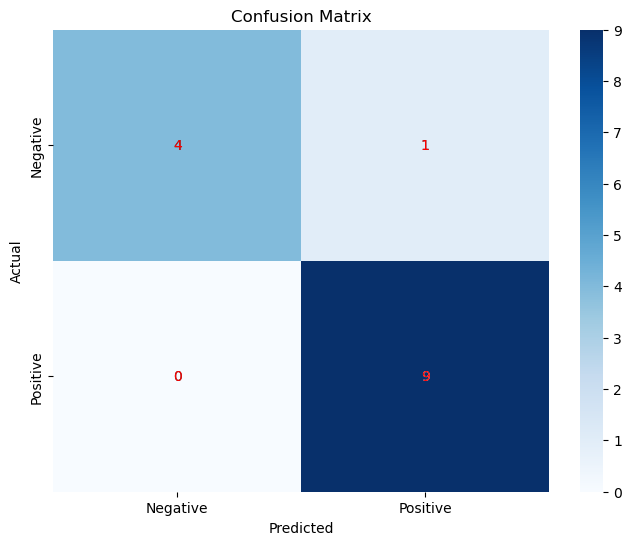

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# For Random Forest
y_pred_prob = rf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob > 0.5).astype("int32")

# Evaluation
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        plt.text(j + 0.5, i + 0.5, f'{conf_matrix[i, j]}',
                 ha='center', va='center', color='red')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



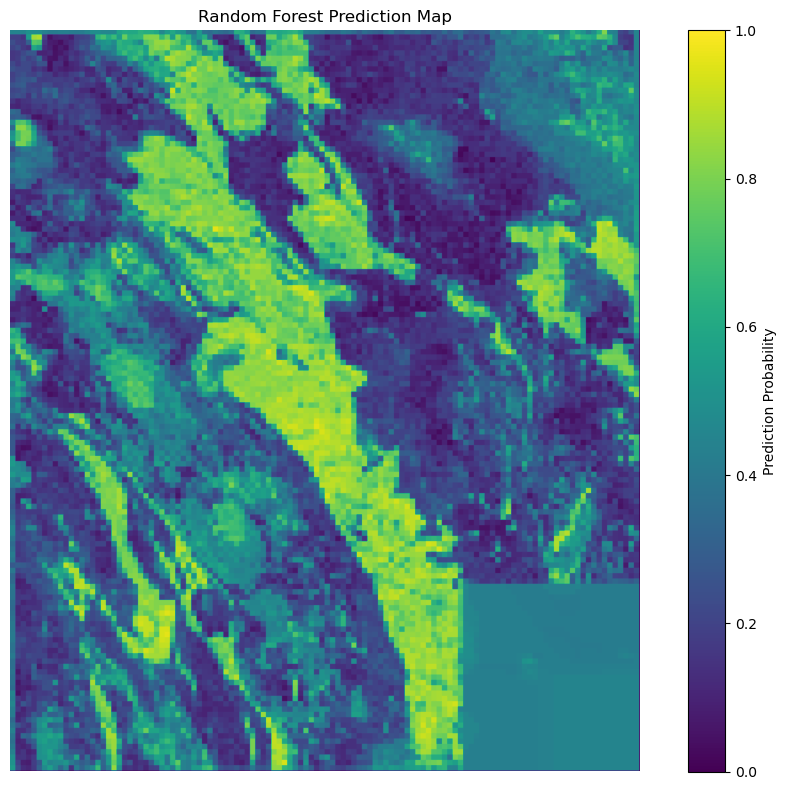

In [8]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
# from joblib import load  # if you're loading a saved model

# Load raster
raster_path = r'cu_input.tiff'
with rasterio.open(raster_path) as src:
    raster_data = src.read().transpose((1, 2, 0))  # (height, width, bands)
    height, width, bands = raster_data.shape
    src_transform = src.transform
    src_crs = src.crs

# Patch config
patch_size = 32

# Create patches from raster
patches = []
patch_coords = []

for i in range(0, height, patch_size):
    for j in range(0, width, patch_size):
        patch = raster_data[i:i+patch_size, j:j+patch_size]
        if patch.shape == (patch_size, patch_size, bands):
            patches.append(patch)
            patch_coords.append((i, j))

patches = np.array(patches)
X = patches.reshape(patches.shape[0], -1)  # Flatten: (n_samples, patch_size × patch_size × bands)

# Predict using Random Forest
rf_probs = rf.predict_proba(X)[:, 1]  # Probability of class 1

# Create prediction map
prediction_map = np.zeros((height, width))

for idx, (i, j) in enumerate(patch_coords):
    prediction_map[i:i+patch_size, j:j+patch_size] = rf_probs[idx]

# --------- Visualization ----------
plt.figure(figsize=(10, 8))
plt.imshow(prediction_map, cmap='viridis', alpha=1.0, vmin=0, vmax=1)
plt.colorbar(label='Prediction Probability')
plt.title('Random Forest Prediction Map')
plt.axis('off')
plt.tight_layout()
plt.show()


In [9]:
import rasterio
from rasterio.transform import from_origin

# Define the path where you want to save the output TIFF file
output_tiff = 'prediction_map_rf_89.tiff'

# Define the metadata for the new raster (copying from the input raster metadata)
with rasterio.open(raster_path) as src:
    metadata = src.meta

# Update the metadata to match the output map's shape and datatype
metadata.update({
    'dtype': 'float32',  # Or choose appropriate datatype
    'count': 1,  # Only one band (for prediction map)
    'crs': src.crs,  # Same CRS as the original raster
    'transform': src.transform,  # Same transform as the original raster
})

# Write the prediction map to a new TIFF file
with rasterio.open(output_tiff, 'w', **metadata) as dst:
    dst.write(prediction_map, 1)  # Write the prediction map to the first band
